# RadxRate Tutorial

---

This interactive tutorial takes you through the steps of how to run RadxRate. RadxRate builds upon the capabilities of RadxKdp and RadxPid by calculating hourly rain rates at each radar gate depending on the local PID category and polarimetric values. It shares parameters files with those two applications. RadxRate will calculate the rain rates with either raw or attenuated-corrected data; the user can choose the option they prefer. The three-dimensional rain rates produced by RadxRate can be then used in RadxQpe to estimate the rain rate closest to the surface, after accounting for beam blockage, noise, and clutter.

A visual comparison of RadxKdp, RadxPid, and RadxRate and their parameter files is shown below. Each application has its own main parameter file that defines variable names and specifies the paths to the parameter file for each relevant sub-process. For example, the main RadxRate parameter file links to the KDP, PID, and rate parameter files (the PID parameter file links to the PID thresholds file).

<div>
<img src="../../ams2023/images/radx_echo_description.png" width="600"/>
</div>

---

*Note: this tutorial is just one type of workflow to use RadxRate. There are several other workflows!*

---

## Tutorial Overview
### 1. Setup

#### Directory organization

The structure of the echo tutorial on JupyterHub is shown in the diagram below. The parent or base directory is "ams2023" and contains all of the notebooks, parameter files, and data for the workshop.

<div>
<img src="../../ams2023/images/RadxRate_structure.png" width="500"/>
</div>

#### Download raw data and parameter files

Raw data files that will be downloaded:
* gfsanl_4_2018091418.g2.tar
* cfrad.20220729_080113.268_to_20220729_080615.642_SEAPOL_SUR.nc
* cfrad.20220729_080847.591_to_20220729_081136.053_SEAPOL_RHI.nc

Parameter files (included in this tutorial):

*Note: The parameter files have already been modified to run straight out of the box.* 
* Grib2toMdv params
* Mdv2SoundingSpdb params
* RadxRate main params
* RadxRate Kdp_specific params
* RadxRate Pid_specific params
* RadxRate Rate_specific params
* Pid Thresholds params (C-band, simultaneous transmit)

### 2. Prepare data for analysis

The data have already been prepared for this tutorial by converting to cfradial and running a quality control algorithm.
We also preprocessed a model sounding file to use in the PID for these cases.


### 3. Run RadxRate

* Calculate KDP, run PID algorithm, estimate three-dimensional precipitation rates
    * RadxRate

### 4. Plot PID and Rate

* Visualize results of RadxRate analysis using Py-ART

---

For this tutorial, the parameter files have already been created and populated with the appropriate parameters. However, the default parameter files can be saved using the following commands.

In [1]:
# # create original parameter files
# !/usr/local/lrose/bin/Grib2toMdv -print_params > /home/jovyan/ams2023/params/user/Grib2toMdv_params_user
# !/usr/local/lrose/bin/Mdv2SoundingSpdb -print_params > /home/jovyan/ams2023/params/user/Mdv2SoundingSpdb_params_user
# !/usr/local/lrose/bin/RadxRate -print_params > /home/jovyan/ams2023/params/user/RadxRate_main_params_user
# !/usr/local/lrose/bin/RadxRate -print_params_kdp > /home/jovyan/ams2023/params/user/RadxRate_Kdp_params_user
# !/usr/local/lrose/bin/RadxRate -print_params_pid > /home/jovyan/ams2023/params/user/RadxRate_Pid_params_user
# !/usr/local/lrose/bin/RadxRate -print_params_rate > /home/jovyan/ams2023/params/user/RadxRate_rate_params_user

# to create new parameter files that use parameters from another file
# !/usr/local/lrose/bin/RadxRate -params /path/to/params -print_params > /home/jovyan/ams2023/params/user/RadxRate_main_params_user

# for command line options
# !/usr/local/lrose/bin/RadxRate -h


# 1. Setup
## Environment and packages

First, we import the required python packages to run this notebook. Most of the LROSE processing can be done with the os package and shell commands. At the end we will plot the output using Py-ART.

In [2]:
import os
import pyart
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import numpy as np


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



<frozen importlib._bootstrap>:283: DeprecationWarning: the load_module() method is deprecated and slated for removal in Python 3.12; use exec_module() instead


Next, we set up the directory structure to simplify our commands. If you are running this notebook at the LROSE workshop on JupyterHub, these paths go to the parent directory containing all the workshop resources and the LROSE binaries. 

**If you have downloaded this notebook, please modify BASE_DIR and LROSE_DIR to work on your personal machine.**

* BASE_DIR: the base directory containing the directories for the notebooks, parameter files
* DATA_DIR: the base directory containing the directories for the data
* RADAR_NAME: the name of the radar used in this tutorial
* LROSE_DIR: path to the LROSE installation 

Note that we are setting both the *system* directories for LROSE to use, *and* the paths in python for reading the data.

In [3]:
os.environ['BASE_DIR'] = '/home/jovyan/ams2023/'
os.environ['DATA_DIR'] = '/home/jovyan/uh2023/data/'

os.environ['RADAR_NAME'] = 'SEA-POL'
os.environ['LROSE_DIR'] = '/usr/local/lrose/bin'
base_dir = os.environ['BASE_DIR']
data_dir = '/home/jovyan/ams2023/data/seapol/'
radar_name = os.environ['RADAR_NAME']
!echo "Base directory: "$BASE_DIR
!echo "Radar name: "$RADAR_NAME
!echo "LROSE directory: "$LROSE_DIR

Base directory: /home/jovyan/ams2023/
Radar name: SEA-POL
LROSE directory: /usr/local/lrose/bin


## Data download and directory set up

We need to set up the required data directories and download the radar data and GFS analysis to the JupyterHub. We delete any existing files and directories specific to this tutorial to ensure we're starting with clean directories and files.

In [4]:
# ## make a directory for all the data files in the echo tutorial (raw and analysis)
# !rm -rf ${BASE_DIR}/data/echo
# !mkdir -p ${BASE_DIR}/data/echo

# ## make subdirectory within data for the raw data
# !rm -rf ${BASE_DIR}/data/echo/raw
# !mkdir ${BASE_DIR}/data/echo/raw

# ## make subdirectory within data for sounding data
# !rm -rf ${BASE_DIR}/data/echo/sounding
# !mkdir ${BASE_DIR}/data/echo/sounding

# ## wget raw files from EOL server
# !wget http://front.eol.ucar.edu/data/notebooks/ams2023/gfsanl_4_2018091418.g2.tar
# !wget http://front.eol.ucar.edu/data/notebooks/ams2023/KMHX20180914_191822_V06.ar2v

# ## move files to proper directory
# !mv KMHX20180914_191822_V06.ar2v ${BASE_DIR}/data/echo/raw
# !mv gfsanl_4_2018091418.g2.tar ${BASE_DIR}/data/echo/raw


In [5]:
surname = 'cfrad.20220729_080113.268_to_20220729_080615.642_SEAPOL_SUR.nc'
datadir = '/home/jovyan/uh2023/data/'
sur_file = f'{datadir}{surname}'
print(sur_file)

/home/jovyan/uh2023/data/cfrad.20220729_080113.268_to_20220729_080615.642_SEAPOL_SUR.nc


We can examine the raw radar file using RadxPrint. RadxPrint can read CfRadial and other raw radar formats supported by LROSE that can later be converted by RadxConvert. It will also provide information on radar variables and sweep information. For example, we can look at the variables using the following command, piping the output into the head command.

In [6]:

# print out the first 50 lines of RadxPrint output
!${LROSE_DIR}/RadxPrint -f ${DATA_DIR}cfrad.20220729_080113.268_to_20220729_080615.642_SEAPOL_SUR.nc | head -50


=============== RadxVol ===============
  convention: CF-1.7
  version: CF-Radial-1.4
  title: RAW_ALL
  institution: 
  references: Conversion software: Radx::SigmetRadxFile
  source: Sigmet IRIS software
  history: Sigmet RAW file: 
  comment: 
  volNum: 161
  scanName: PRECIP_SUR
  scanId(VCP): 0
--------------- RadxPlatform ---------------
  instrumentName: SEAPOL
  siteName: SEAPOL
  instrumentType: radar
  platformType: aircraft
  primaryAxis: axis_z
  latitudeDeg: 24.4567
  longitudeDeg: 122.943
  altitudeKm: 0.007
  sensorHtAglM: 0
  frequencyHz: 5.65646e+09
  radarAntGainDbH: -9999
  radarAntGainDbV: -9999
  radarBeamWidthDegH: 1
  radarBeamWidthDegV: 1
  radarReceiverBandwidthMhz: -9999
--------------------------------------------
  rhiMode? N
  startTimeSecs: 2022/07/29 08:01:13
  startNanoSecs: 2.68e+08
  endTimeSecs: 2022/07/29 08:06:15
  endNanoSecs: 6.42e+08
  ray times are in increasing order
  n sweeps: 13
  n rays: 4680
  n calibs: 1
  n fields: 9
    field[0]: DBZ
  

# 2. Prepare data for analysis
## These files have already been converted to cfradial and quality controlled, so they are ready to go into RadxRate.

In [7]:
!rm -rf ${BASE_DIR}/data/seapol
!mkdir ${BASE_DIR}/data/seapol


### This needs to be updated for whatever sounding we end up inputting.

## Set up the parameter files.

RadxRate will calculate Kdp, Run the PID, and calculate rain rates

<!-- ## Convert from Grib2 (model analysis) to MDV

The program to retrieve the model sounding requires a gridded file format called MDV. Grib2toMdv converts the GFS analysis from GRIB to MDV. Grib2toMdv needs to know where to write the gridded data files, the name of the fields (the defaults are often sufficient), how the grid should be remapped (e.g., map projection), the size of the new grid, and the vertical levels.

- **Important Grib2toMdv Parameters**
    - input_dir [line 69]: optional, if directory is specified in command line
    - write_non_forecast [line 385]: specify if output written in a non-forecast directory structure (*TRUE* or *FALSE*, usually *TRUE*)
    - non_forecast_mdv_url [line 395]: absolute path where MDV files are written
    - output_fields [line 592]: list of output fields, where param matches GRIB files and mdv_name matches Mdv2SoundingSpdb parameter file (defaults are usually sufficient)
    - remap_output [line 755]: specify whether to remap the output (*TRUE* or *FALSE*, usually *TRUE*)
    - out_projection_info [line 793]: set map projection type and radar location if necessary
    - out_grid_info [line 827]: user-specified domain surrounding the region of interest and radar(s)
        - nx/ny - number of points, minx/miny - bottom left lat/lon (deg), dx/dy - delta lon/lat (deg)
    - height_levels [line 916]: user-specified height levels, optional
    
Here, the *-params* flag directs Grib2toMdv to the parameter file and *-f* points to the raw GRIB file path. This can also be specified in the parameter *input_dir*.
 -->

# 3. Setup steps complete, run RadxRate

With the radar data and point sounding, we can now run RadxRate. First, KDP is calculated. Then polarimetric radar data, calculated KDP, and sounding data are used to run PID, which determines the dominant hydrometeor at each range gate. Finally, the 3D field of hourly rain rates are calculated from polarimetric radar and PID data.

Running RadxRate requires one main parameter file on the command line. That parameter file contains  links to the KDP, PID, and rain rate coefficient parameter files. The RadxRate PID parameter file contains the link to the fuzzy logic PID thresholds file. Because there are so many parameters, we have provided them at the end of this notebook. Please refer to [this link](#RadxRad-parameters).

RadxRate requires the field names in the input CfRadial file, whether SNR and LDR are available, the method for KDP calculation, how to calculate the PID, how to calculate the precipitation rates (e.g., equations and coefficients), whether to use attenuation-correction fields, the variables to be written, and whether to censor non-weather gates. 

Here, *-params* provides the link to the main RadxRate parameter file, *-f* provides the link to the files we want to process, and *-outdir* indicates where RadxRate should write the final files.

In [8]:
!${LROSE_DIR}/RadxRate -params ${BASE_DIR}params/seapol/RadxRate_main_params -f ${DATA_DIR}/*.nc -outdir ${BASE_DIR}/data/seapol


# 4. Plot PID and rate for SEAPOL Squall line on 29 July 2022 in Yonaguni, Japan

To visualize the output in the notebook, we can use Py-ART. HawkEye is also great for visualizing data - a general parameter file can be found in the echo parameter files directory.

In [9]:
# Read CfRadial file into radar object
inDir = data_dir+"/20220729/"
file = "cfrad.20220729_080113.268_to_20220729_080615.642_SEAPOL_SUR.nc"
#file = "cfrad.20220729_214909.013_to_20220729_215410.811_SEAPOL_SUR.nc"
rate_seapol = pyart.io.read_cfradial(inDir+file)
rate_seapol.info('compact')


altitude: <ndarray of type: float64 and shape: (4680,)>
altitude_agl: <ndarray of type: float64 and shape: (4680,)>
antenna_transition: <ndarray of type: int8 and shape: (4680,)>
azimuth: <ndarray of type: float32 and shape: (4680,)>
elevation: <ndarray of type: float32 and shape: (4680,)>
fields:
	RATE_ZH: <ndarray of type: float32 and shape: (4680, 1197)>
	RATE_KDP: <ndarray of type: float32 and shape: (4680, 1197)>
	RATE_HYBRID: <ndarray of type: float32 and shape: (4680, 1197)>
	PID: <ndarray of type: float32 and shape: (4680, 1197)>
	KDP: <ndarray of type: float32 and shape: (4680, 1197)>
	DBZ_ATTEN_CORRECTED: <ndarray of type: float32 and shape: (4680, 1197)>
	ZDR_ATTEN_CORRECTED: <ndarray of type: float32 and shape: (4680, 1197)>
	DBZ: <ndarray of type: float32 and shape: (4680, 1197)>
	VEL: <ndarray of type: float32 and shape: (4680, 1197)>
	ZDR: <ndarray of type: float32 and shape: (4680, 1197)>
fixed_angle: <ndarray of type: float32 and shape: (13,)>
instrument_parameters:
	f

In [10]:
pfile = "cfrad.20220729_080847.591_to_20220729_081136.053_SEAPOL_RHI.nc"
#pfile = "cfrad.20220729_214806.187_to_20220729_214906.248_SEAPOL_RHI.nc"
pid_seapol = pyart.io.read_cfradial(inDir+pfile)
pid_seapol.info('compact')


altitude: <ndarray of type: float64 and shape: (2029,)>
altitude_agl: <ndarray of type: float64 and shape: (2029,)>
antenna_transition: <ndarray of type: int8 and shape: (2029,)>
azimuth: <ndarray of type: float32 and shape: (2029,)>
elevation: <ndarray of type: float32 and shape: (2029,)>
fields:
	RATE_ZH: <ndarray of type: float32 and shape: (2029, 1197)>
	RATE_KDP: <ndarray of type: float32 and shape: (2029, 1197)>
	RATE_HYBRID: <ndarray of type: float32 and shape: (2029, 1197)>
	PID: <ndarray of type: float32 and shape: (2029, 1197)>
	KDP: <ndarray of type: float32 and shape: (2029, 1197)>
	DBZ_ATTEN_CORRECTED: <ndarray of type: float32 and shape: (2029, 1197)>
	ZDR_ATTEN_CORRECTED: <ndarray of type: float32 and shape: (2029, 1197)>
	DBZ: <ndarray of type: float32 and shape: (2029, 1197)>
	VEL: <ndarray of type: float32 and shape: (2029, 1197)>
	ZDR: <ndarray of type: float32 and shape: (2029, 1197)>
fixed_angle: <ndarray of type: float32 and shape: (9,)>
instrument_parameters:
	fr

We can create a colormap for visualizing PID.

In [11]:
pidmap = np.array([[0.12156862745098039, 0.46666666666666667, 0.70588235294117652, 1.0],
              [0.68235294117647061, 0.7803921568627451, 0.90980392156862744, 1.0],
              [0.59607843137254901, 0.87450980392156863, 0.54117647058823526, 1.0],
              [0.45490196078431372, 0.7686274509803922, 0.46274509803921571, 1.0],
              [0.17254901960784313, 0.62745098039215685, 0.17254901960784313, 1.0],
              [0.83921568627450982, 0.15294117647058825, 0.15686274509803921, 1.0],
              [1.0, 0.59607843137254901, 0.58823529411764708, 1.0],
              [1.0, 0.49803921568627452, 0.054901960784313725, 1.0],
              [1.0, 0.73333333333333328, 0.47058823529411764, 1.0],
              [0.61960784313725492, 0.85490196078431369, 0.89803921568627454, 1.0],
              [0.090196078431372548, 0.74509803921568629, 0.81176470588235294, 1.0],
              [0.61176470588235299, 0.61960784313725492, 0.87058823529411766, 1.0],
              [0.32156862745098042, 0.32941176470588235, 0.63921568627450975, 1.0],
              [0.859375, 0.859375, 0.859375, 1.0],
              [0.66015625, 0.66015625, 0.66015625, 1.0],
              [0.41015625, 0.41015625, 0.41015625, 1.0],
              [0.0, 0.0, 0.0, 1.0],],'f')
my_cmap2 = colors.ListedColormap(pidmap, name='ncar_pid')


In [12]:
# surx_min= -10
# surx_max = 60
# sury_min = 0 
# sury_max = 70

In [13]:
surx_min= -75
surx_max = 75
sury_min = -75 
sury_max = 75

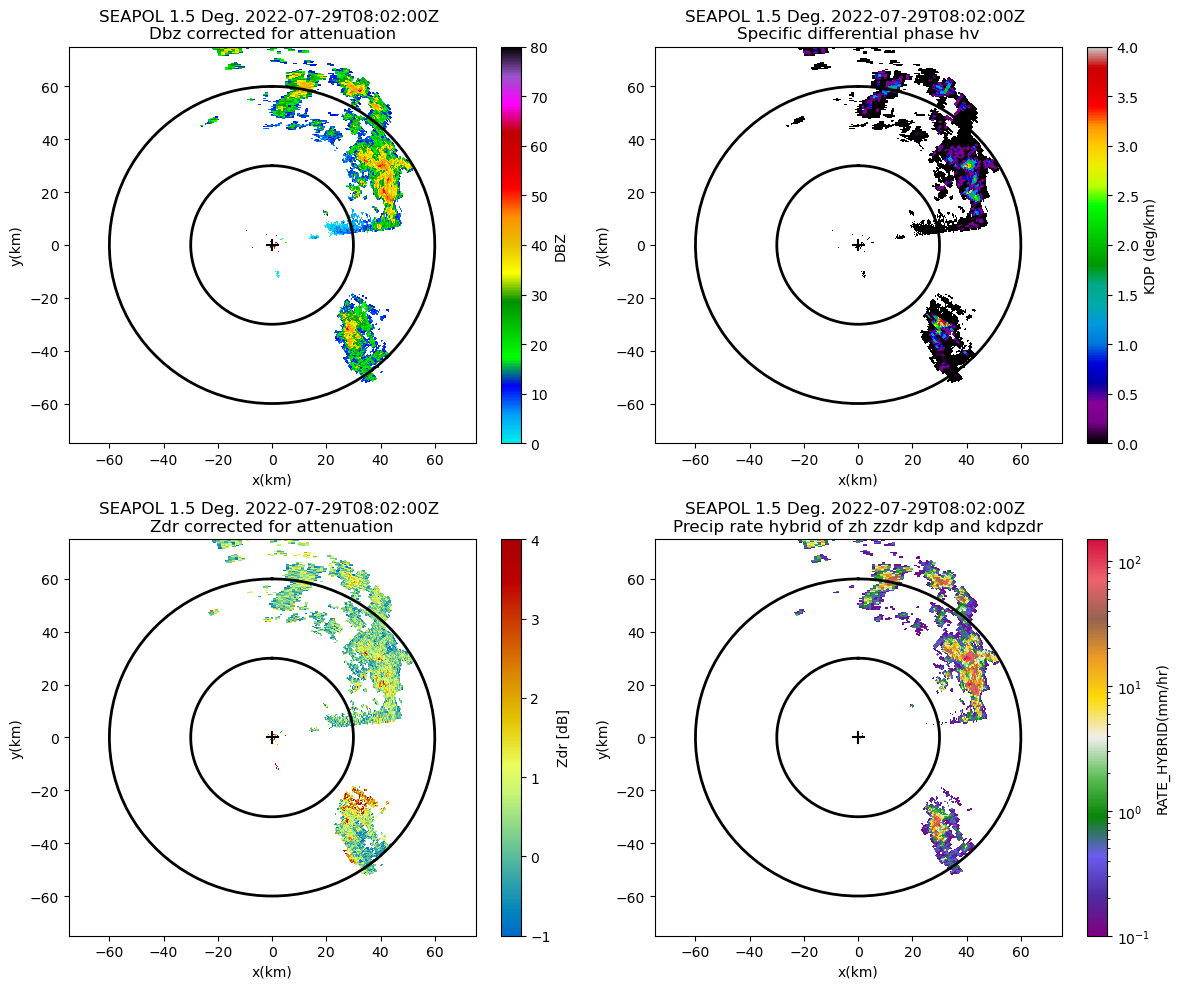

In [17]:
# Plot results of RadxRate

displayRate = pyart.graph.RadarDisplay(rate_seapol)
figRate = plt.figure(1, (12, 10))

# DBZ (input)

axDbz = figRate.add_subplot(221)
displayRate.plot_ppi('DBZ_ATTEN_CORRECTED', 2, vmin=0, vmax=80.,
                    axislabels=("x(km)", "y(km)"),cmap='pyart_NWSRef',
                    colorbar_label="DBZ")
displayRate.set_limits(xlim=[surx_min,surx_max],ylim=[sury_min,sury_max])
displayRate.plot_range_rings([30, 60])#, 150, 200, 250])
displayRate.plot_cross_hair(2.)
#displayRate.set_limits(xlim=(-70,70),ylim=(-70,70))

# KDP (computed)

axKdp = figRate.add_subplot(222)
displayRate.plot_ppi('KDP', 2, vmin=0, vmax=4.,
    axislabels=("x(km)", "y(km)"),
    colorbar_label="KDP (deg/km)",
    cmap="nipy_spectral")
displayRate.set_limits(xlim=[surx_min,surx_max],ylim=[sury_min,sury_max])
displayRate.plot_range_rings([30, 60])#, 150, 200, 250])
displayRate.plot_cross_hair(2.)
# displayRate.set_limits(xlim=(-300,300),ylim=(-300,300))



#ZDR (input)

axZdr = figRate.add_subplot(223)
displayRate.plot_ppi('ZDR_ATTEN_CORRECTED', 2,cmap='pyart_HomeyerRainbow',vmin=-1,vmax=4,
    axislabels=("x(km)", "y(km)"),
    colorbar_label="Zdr [dB]",
    mask_outside=True)
displayRate.plot_range_rings([30, 60])#, 150, 200, 250])
displayRate.plot_cross_hair(2.)
displayRate.set_limits(xlim=[surx_min,surx_max],ylim=[sury_min,sury_max])

# RATE_HYBRID (computed)

axHybrid = figRate.add_subplot(224)
displayRate.plot_ppi('RATE_HYBRID', 2, norm=colors.LogNorm(vmin=0.1, vmax=150),
    axislabels=("x(km)", "y(km)"),
    colorbar_label="RATE_HYBRID(mm/hr)",
    cmap = "pyart_RRate11")
displayRate.plot_range_rings([30, 60])#, 150, 200, 250])
displayRate.plot_cross_hair(2.)
displayRate.set_limits(xlim=[surx_min,surx_max],ylim=[sury_min,sury_max])


figRate.tight_layout()

plt.show()


In [15]:
pid_seapol.fields.keys()

dict_keys(['RATE_ZH', 'RATE_KDP', 'RATE_HYBRID', 'PID', 'KDP', 'DBZ_ATTEN_CORRECTED', 'ZDR_ATTEN_CORRECTED', 'DBZ', 'VEL', 'ZDR'])

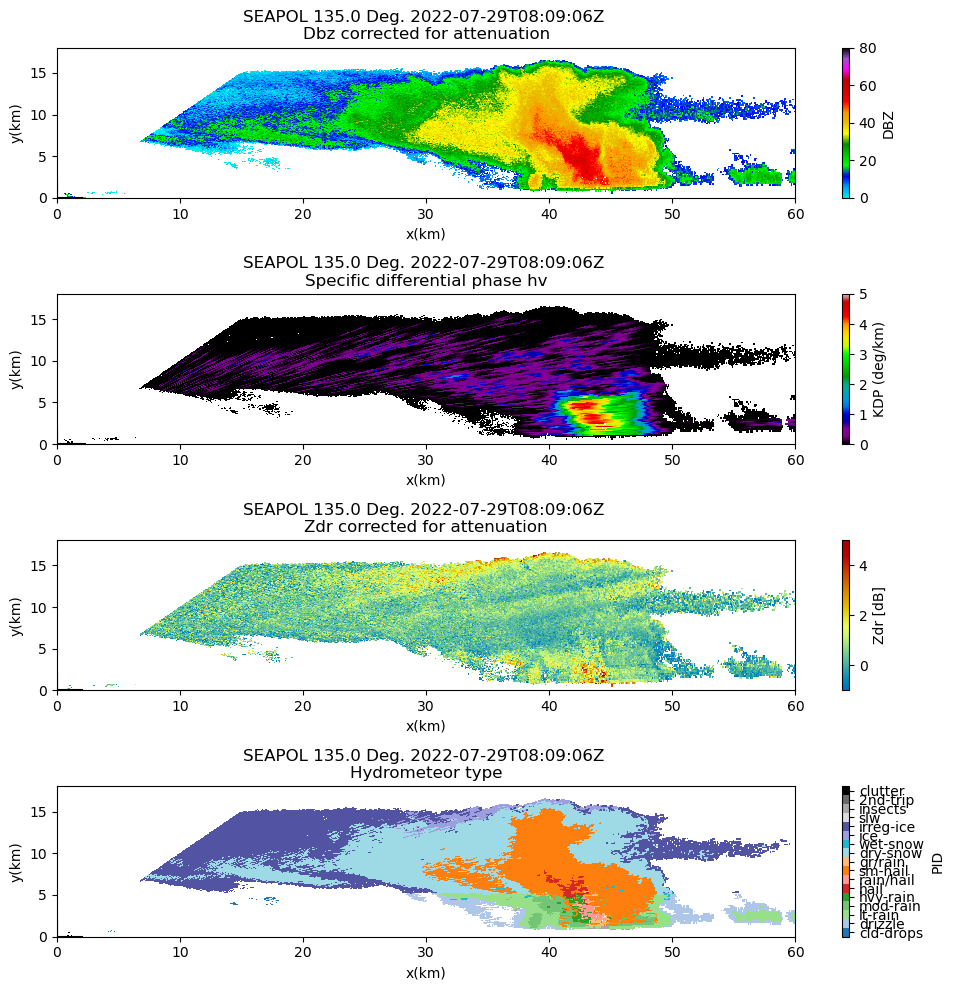

In [16]:
# Plot results of RadxRate

displayRate = pyart.graph.RadarDisplay(pid_seapol)
figRate = plt.figure(1, (10, 10))

# DBZ (input)

swp = 1

axDbz = figRate.add_subplot(411)
displayRate.plot_rhi('DBZ_ATTEN_CORRECTED', swp, vmin=0, vmax=80.,
                    axislabels=("x(km)", "y(km)"),cmap='pyart_NWSRef',
                    colorbar_label="DBZ")
displayRate.set_limits(xlim=[0,60],ylim=[0,18])
#displayRate.plot_range_rings([30, 60])#, 150, 200, 250])
displayRate.plot_cross_hair(2.)
#displayRate.set_limits(xlim=(-300,300),ylim=(-300,300))

# KDP (computed)

axKdp = figRate.add_subplot(412)
displayRate.plot_rhi('KDP', swp, vmin=0, vmax=5.,
    axislabels=("x(km)", "y(km)"),
    colorbar_label="KDP (deg/km)",
    cmap="nipy_spectral")
displayRate.set_limits(xlim=[0,60],ylim=[0,18])
#displayRate.plot_range_rings([30, 60])#, 150, 200, 250])
displayRate.plot_cross_hair(2.)
# displayRate.set_limits(xlim=(-300,300),ylim=(-300,300))


axZdr = figRate.add_subplot(413)
displayRate.plot_rhi('ZDR_ATTEN_CORRECTED', swp, vmin=-1, vmax = 5,
    axislabels=("x(km)", "y(km)"),
    colorbar_label="Zdr [dB]",
    cmap = 'pyart_HomeyerRainbow', mask_outside=True)


#'pyart_SCook18
#displayRate.plot_range_rings([30, 60])#, 150, 200, 250])
displayRate.plot_cross_hair(2.)
displayRate.set_limits(xlim=[0,60],ylim=[0,18])
#displayRate.set_limits(xlim=[surx_min,surx_max],ylim=[sury_min,sury_max])

# # RATE_HYBRID (computed)

# axHybrid = figRate.add_subplot(313)
# displayRate.plot_rhi('RATE_HYBRID', 0, vmin=0, vmax=50.,
#     axislabels=("x(km)", "y(km)"),
#     colorbar_label="RATE_HYBRID(mm/hr)",
#     cmap = "pyart_RRate11")
# #displayRate.plot_range_rings([30, 60])#, 150, 200, 250])
# displayRate.plot_cross_hair(2.)
# displayRate.set_limits(xlim=[0,60],ylim=[0,18])

# NCAR PID (computed)

axPID = figRate.add_subplot(414)
displayRate.plot_rhi('PID', swp, vmin=0.5, vmax = 17.5,
    axislabels=("x(km)", "y(km)"),
    colorbar_label="PID",
    cmap = my_cmap2, mask_outside=True)
#    cmap = 'pyart_PD17', mask_outside=True)
#displayRate.plot_range_rings([30, 60])#, 150, 200, 250])
displayRate.plot_cross_hair(2.)
displayRate.set_limits(xlim=[0,60],ylim=[0,18])

# plot all 17 PID categories
pid_cbar = displayRate.cbs[3]
#pid_cbar.set_ticks([1,2,3,4,5,6,7,8,9,10,11,12,13])
#pid_cbar.set_ticklabels(['cld-drops', 'drizzle', 'lt-rain', 'mod-rain', 'hvy-rain', 'hail', 'rain/hail', 'sm-hail', 'gr/rain', 'dry-snow', 'wet-snow', 'ice', 'irreg-ice'])
pid_cbar.set_ticks([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17])
pid_cbar.set_ticklabels(['cld-drops', 'drizzle', 'lt-rain', 'mod-rain', 'hvy-rain', 'hail', 'rain/hail', 'sm-hail', 'gr/rain', 'dry-snow', 'wet-snow', 'ice', 'irreg-ice', 'slw', 'insects', '2nd-trip', 'clutter'])



figRate.tight_layout()

plt.show()


# 5. Extras

<a id=’RadxRate-parameters’></a>
## **RadxRate parameters**

Below is a list of important RadxRate parameters. The line numbers are accurate as of Dec 2022 for the final Topaz release of LROSE. 

* **RadxRate main parameters**
    * input_dir [line 105]: path to input data, can be specified on command line
    * INPUT FIELD INFORMATION [line 155]: must match input file variable names
        * here SNR_available = FALSE [line 177]
        * here DBZ_field_name = "REF" [line 215]
        * here LDR_available = FALSE [line 255]
    * kdp_params_file_path [line 284]: path to Kdp-specific parameter file
    * pid_params_file_path [line 303]: path to PID-specific parameter file
    * PID_use_attenuation_corrected_fields [line 331]: specify whether to use attenuation-corrected DBZ and ZDR in PID
    * RATE_params_file_path [line 350]: path to precipitation rate coefficients parameter file
    * RATE_use_attenuation_corrected_fields [line 378]: specify whether to use attenuation-corrected DBZ and ZDR in precipitation rate calculation
    * output_dir [line 699]: path where output files are written, can set on command line with -outdir
    * output_format [line 755]: output file format, usually CfRadial
* **RadxRate Kdp_specific parameters**
    * KDP_fir_filter_len [line 65]: filter length used for KDP calculation
        * here KDP_FIR_LEN_10
    * KDP_psob_method [line 114]: specify method to remove phase shift on backscatter
        * here PEAK_REMOVAL_METHOD
* **RadxRate Pid_specific parameters**
    * PID_thresholds_file_path [line 27]: path to fuzzy logic PID thresholds file
    * PID_use_soundings_from_spdb [line 303]: specify whether soundings are in Spdb format, otherwise sounding found in fuzzy logic file
        * here TRUE
    * PID_sounding_spdb_url [line 313]: path to Spdb soundings
    * PID_sounding_location_name [line 339]: name of sounding location
        * here $(RADAR_NAME)
* **RadxRate Rate_specific parameters**
    * RATE_zh_aa [line 154]: R(Z) coefficients
    * RATE_zh_bb [line 164]: R(Z) coefficients
    * RATE_zh_aa_snow [line 182]: R(Z) coefficients in snow
    * RATE_zh_bb_snow [line 192]: R(Z) coefficients in snow
    * RATE_zzdr_aa [line 210]: R(Z, ZDR) coefficients
    * RATE_zzdr_bb [line 220]: R(Z, ZDR) coefficients
    * RATE_zzdr_cc [line 230]: R(Z, ZDR) coefficients
    * RATE_kdp_aa [line 248]: R(KDP) coefficients
    * RATE_kdp_bb [line 258]: R(KDP) coefficients
    * RATE_kdpzdr_aa [line 277]: R(KDP, ZDR) coefficients
    * RATE_kdpzdr_bb [line 287]: R(KDP, ZDR) coefficients
    * RATE_kdpzdr_cc [line 297]: R(KDP, ZDR) coefficients
* **Pid Thresholds parameters**
    * Radar dependent
        * NEXRAD is S-band simultaneous h/v transmission and recieving
        * Other parameter files can be found [here](http://wiki.lrose.net/index.php/RadxPid#PID_thresholds_file)
